In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter_tempered_jittered
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

True


Initialisation of a twin experiment. 

In [2]:
signal_params = ConfigDict(KDV_params_2_SALT)
print(signal_params)
ensemble_params = ConfigDict(KDV_params_2_SALT)
ensemble_params.update(E=1,P=32,stochastic_advection_basis='constant')
ensemble_params.update(E=128,P=32,stochastic_advection_basis='constant')

Advection_basis_name: constant
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.01
nx: 256
tmax: 4
xmax: 1
xmin: 0



Now we specify the models, by calling the class.

In [3]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

multinomial, systematic, no_resampling, default


In [4]:
observation_spatial_frequency = 4
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.01
number_of_observations_time = int(ensemble_model.nt/1)
observation_temporal_frequency = int(ensemble_model.nt/number_of_observations_time)

print(observation_locations)
print(observation_temporal_frequency)
pf_systematic = ParticleFilter_tempered_jittered(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    seed = 1,
    resampling="default",#'default',
    observation_locations = observation_locations,
)

[  0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68
  72  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140
 144 148 152 156 160 164 168 172 176 180 184 188 192 196 200 204 208 212
 216 220 224 228 232 236 240 244 248 252]
1


In [5]:
out = pf_systematic.run_step(initial_ensemble, initial_signal)

In [6]:
print(len(out))
ps, ss, obser = out
print(ps.shape, ss.shape, obser.shape)
jnp.count_nonzero(obser)


3
(128, 256) (1, 256) (1, 256)


Array(64, dtype=int64)

In [7]:
da_steps = number_of_observations_time
final, all = pf_systematic.run(initial_ensemble, initial_signal, da_steps) #the final input is scan length? 

Put in the initial condition.

In [8]:
particles =jnp.concatenate([initial_ensemble[None,...], all[0]], axis=0)
signal = jnp.concatenate([initial_signal[None,...], all[1]], axis=0)
observations = jnp.concatenate([initial_signal[None,...], all[2]], axis=0)
observations = all[2][:,:, observation_locations]
print(observations.shape)
print(particles.shape)

(4000, 1, 64)
(4001, 128, 256)


In [ ]:
def plot_all(da_step):
    plt.figure(figsize=(12, 6))
    # Plot signal
    plt.plot(signal_model.x, signal[da_step, 0, :], color='k', label='Signal', linewidth=2)
    # Plot all particles
    plt.plot(signal_model.x, particles[da_step, :, :].T, color='b', linewidth=0.5, alpha=0.5, label='Particles')
    # Plot observations
    if da_step > 0:
        plt.scatter(signal_model.x[observation_locations], observations[da_step - 1, 0, :], color='r', label='Observations', zorder=5)
    plt.xlabel('Spatial Domain', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.title(f'Data Assimilation Step {da_step}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

interact(plot_all, da_step=(0, da_steps))

interactive(children=(IntSlider(value=2000, description='da_step', max=4000), Output()), _dom_classes=('widget…

<function __main__.plot_all(da_step)>

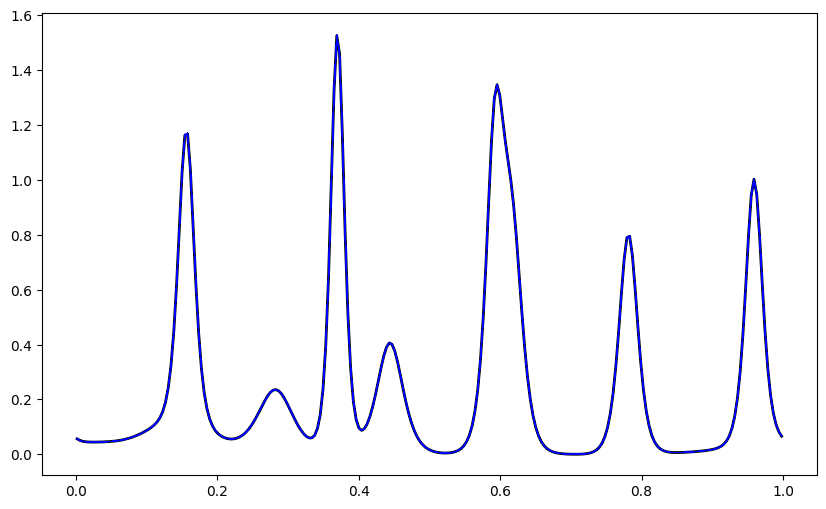

interactive(children=(IntSlider(value=2000, description='da_step', max=4000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

In [10]:
def plot(da_step):
    plt.figure(figsize=(10, 6))
    plt.plot(signal_model.x, signal[da_step, 0, :], color='k', label='Signal', linewidth=2)
    plt.plot(signal_model.x, particles[da_step, 0, :].T, color='b', label='Particles', linewidth=0.5, alpha=0.5)

    plt.plot(signal_model.x, particles[da_step, :, :].T, color='b', linewidth=0.5, alpha=0.5)
    if da_step > 0:
        plt.scatter(signal_model.x[observation_locations], observations[da_step - 1, 0, 0], color='r', label='Observations', zorder=5)

        plt.scatter(signal_model.x[observation_locations], observations[da_step - 1, 0, :], color='r', zorder=5)
    plt.xlabel('Spatial Domain', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.title(f'Data Assimilation Step {da_step}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    #plt.tight_layout()
    plt.show()
interact(plot, da_step=(0, da_steps))